# Idai

Notebook to calculate impacts of Cyclone Idai across gridded raster products

In [2]:
#### Dependencies
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from rasterstats import zonal_stats, gen_zonal_stats
from glob import glob
import matplotlib.pyplot as plt

In [3]:
# open polys
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'

In [4]:
#### Functions
def zone_loop(polys_in, rst_list, stats_type, col, split):
    """ Function loops through rasters, calcs zonal_stats and returns stats as a data frame.
    Args:
        polys_in = polygons
        rst_list = list of paths & fns of rasters
        stats_type = stats type for each poly gone (see zonal stats)
        col = column to merge it all
        split = where to split the file name string (e.g. _matched.tif)
    """
    
    # copy polys to write out
    polys_out = polys_in.copy()
    
    for rst in rst_list:
        
        # Get data name
        data = rst.split(DATA_PATH+'interim/')[1].split(split)[0]
        print('Started', data)
        
        # Run zonal stats
        zs_feats = zonal_stats(polys_in, rst, stats=stats_type, geojson_out=True)
        zgdf = gpd.GeoDataFrame.from_features(zs_feats, crs=polys_in.crs)
        
        # Rename columns and merge
        zgdf = zgdf.rename(columns={stats_type: data+'_'+stats_type})
        
        polys_out = polys_out.merge(zgdf[[col, data+'_'+stats_type]], on = col, how = 'inner')
    
    return polys_out

## Wind speeds
https://www.gdacs.org/resources.aspx?eventid=1000552&episodeid=24&eventtype=TC (I think)

In [5]:
shps_fn = DATA_PATH+'raw/Idai/GDACS/Shape_1000552_24/Shape_1000552_24_POLYGON.shp'
shps = gpd.read_file(shps_fn)

In [6]:
shps

,eventtype,eventid,episodeid,source,type,label,geometry
0,TC,1000552,24,JTWC,Red,120 km/h,"POLYGON ((36.30000 -20.56700, 36.27524 -20.566..."
1,TC,1000552,24,JTWC,Green,60 km/h,"POLYGON ((36.30000 -22.31900, 36.21022 -22.317..."
2,TC,1000552,24,JTWC,Orange,90 km/h,"POLYGON ((36.30000 -21.23400, 36.25049 -21.233..."
3,TC,1000552,24,JTWC,Cones,Uncertainty Cones,"POLYGON ((31.40000 -20.20200, 31.32645 -20.200..."


In [7]:
# Make a Geodataframe of wind polygobns
labels = shps.label[[1,2,0]] # Get labels 60, 90, 120
geom120 = shps.iloc[0,6] # geom for speeds
geom90 = shps.iloc[[2]].geometry[2].difference(shps.iloc[[0]].geometry[0])
geom60 = shps.iloc[[1]].geometry[1].difference(shps.iloc[[2]].geometry[2].union(shps.iloc[[0]].geometry[0]))

In [8]:
polys = gpd.GeoDataFrame()
polys['label'] = labels
polys['geometry'] = [geom60, geom90, geom120]
polys.to_file(DATA_PATH+'/interim/Idai_winds.shp')

In [9]:
# Run zonal stats on all 
# Git tif files
rst_fns = sorted(glob('/Users/cascade/Github/PopGridCompare/data/interim/*all_M-M-Z.tif'))
col = 'label'
winds_all = zone_loop(polys, rst_fns, 'sum', col, '_all_M-M-Z.tif')
winds_all['label_int'] = [60, 90, 120]

Started ESRI16
Started GHS15
Started GPWv4
Started LS15
Started WP16


In [109]:
# Run zonal stats on rural 
rst_fns = sorted(glob('/Users/cascade/Github/PopGridCompare/data/interim/*rural_M-M-Z.tif'))
col = 'label'
winds_rural = zone_loop(polys, rst_fns, 'sum', col, '_rural_M-M-Z.tif')
winds_rural['label_int'] = [60, 90, 120]

Started ESRI16
Started GHS15
Started GPWv4
Started LS15
Started WP16


## Flooding
This should be updated once we decide on which flood extent method to employ

In [68]:
def flood_sum(flood_arr, rst_fn):
    """ sums total population from a rst affected by a flood mask raster
    Args:
        flood_arr = binary array of flood impacts
        rst_fn = population raster input
    """
    pop_arr = rasterio.open(rst_fn).read(1) # open
    pop_arr_zeros = np.where(pop_arr == -999, 0, pop_arr) # revalue
    mask_arr = flood_arr * pop_arr_zeros
    
    pop_sum = mask_arr.flatten().sum()
    return pop_sum

In [69]:
# Paths
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'

In [70]:
# Get flood mask
flood_fn = DATA_PATH+'interim/Idai_flood1km-matched.tif'
flood_arr = rasterio.open(flood_fn).read(1)

In [76]:
# Get all pop rasters
rst_fns = sorted(glob('/Users/cascade/Github/PopGridCompare/data/interim/*all_M-M-Z.tif'))

In [89]:
# Get all pop rasters
rst_fns = sorted(glob('/Users/cascade/Github/PopGridCompare/data/interim/*all_M-M-Z.tif'))

# Loop through and get flood impact data
cols = []
floods = []
for rst_fn in rst_fns:
    
    # get cols
    col = rst_fn.split('interim/')[1].split('_all')[0]+'_sum'
    cols.append(col)
    
    #get flood
    flood = flood_sum(flood_arr, rst_fn)
    floods.append(flood)

# write to df
floods_all = pd.DataFrame(columns = cols)
floods_all.loc[0] = floods 

In [99]:
floods_all

,ESRI16_sum,GHS15_sum,GPWv4_sum,LS15_sum,WP16_sum
0,892340.0,1.481183e+06,1363058.375,1215242.0,1377915.75


In [93]:
# Get all pop rasters
rst_fns = sorted(glob('/Users/cascade/Github/PopGridCompare/data/interim/*rural_M-M-Z.tif'))

# Loop through and get flood impact data
cols = []
floods = []
for rst_fn in rst_fns:
    
    # get cols
    col = rst_fn.split('interim/')[1].split('_rural')[0]+'_sum'
    cols.append(col)
    
    #get flood
    flood = flood_sum(flood_arr, rst_fn)
    floods.append(flood)

# write to df
floods_rural = pd.DataFrame(columns = cols)
floods_rural.loc[0] = floods 

## Figure

In [128]:
#### set colors
ESRI16_c = 'blue'
GHS15_c = 'indigo'
GWPv4_c = 'deeppink'
LS15_c = 'deepskyblue'
WP16_c = 'forestgreen'

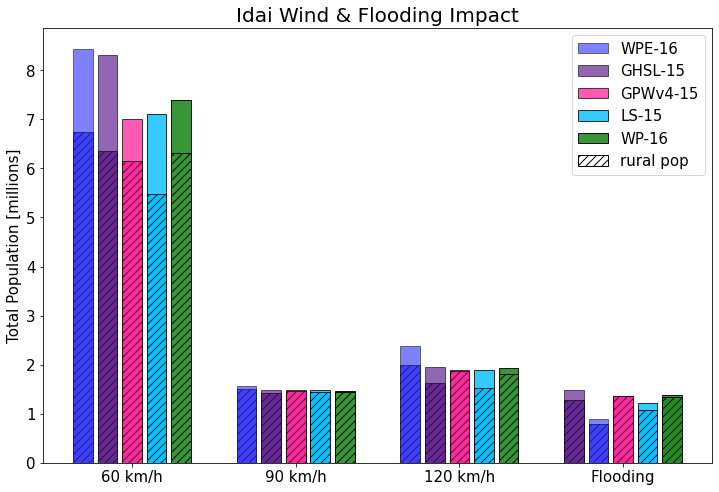

In [130]:
# Make bar plot 
fig, axs = plt.subplots(1, 1, figsize = (12, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)
scale = 10**6

# All winds
# Bar locations
a = [1-.3,2-.3,3-.3]
b = [1-.15,2-.15,3-.15]
c = [1,2,3]
d = [1+.15,2+.15,3+.15]
e = [1+.3,2+.3,3+.3]

# plots
plt.bar(a, winds_all.ESRI16_sum / scale, width=0.12, align='center', alpha  = 0.5, color = ESRI16_c, ec = 'black')
plt.bar(b, winds_all.GHS15_sum / scale, width=0.12, align='center', alpha  = 0.6, color = GHS15_c, ec = 'black')
plt.bar(c, winds_all.GPWv4_sum / scale, width=0.12, align='center', alpha  = 0.7, color = GWPv4_c, ec = 'black')
plt.bar(d, winds_all.LS15_sum / scale, width=0.12, align='center', alpha  = 0.8, color = LS15_c, ec = 'black')
plt.bar(e, winds_all.WP16_sum / scale, width=0.12, align='center', alpha  = 0.9, color = WP16_c, ec = 'black')

# Fake plot for rural hatch legend 
plt.bar(e, winds_rural.WP16_sum / scale, width=0.12, align='center', alpha  = 1, color = 'white', ec = 'black',hatch = "///")

# Rural Winds
# plots
plt.bar(a, winds_rural.ESRI16_sum / scale, width=0.12, align='center', alpha  = 0.5, color = ESRI16_c, ec = 'black', hatch = "///")
plt.bar(b, winds_rural.GHS15_sum / scale, width=0.12, align='center', alpha  = 0.6, color = GHS15_c, ec = 'black', hatch = "///")
plt.bar(c, winds_rural.GPWv4_sum / scale, width=0.12, align='center', alpha  = 0.7, color = GWPv4_c, ec = 'black', hatch = "///")
plt.bar(d, winds_rural.LS15_sum / scale, width=0.12, align='center', alpha  = 0.8, color = LS15_c, ec = 'black', hatch = "///")
plt.bar(e, winds_rural.WP16_sum / scale, width=0.12, align='center', alpha  = 0.9, color = WP16_c, ec = 'black', hatch = "///")

# Bar locations
a = [4-.15]
b = [4-.3]
c = [4]
d = [4+.15]
e = [4+.3]

# All floods 
plt.bar(a, floods_all.ESRI16_sum / scale, width=0.12, align='center', alpha  = 0.5, color = ESRI16_c, ec = 'black')
plt.bar(b, floods_all.GHS15_sum / scale, width=0.12, align='center', alpha  = 0.6, color = GHS15_c, ec = 'black')
plt.bar(c, floods_all.GPWv4_sum  / scale, width=0.12, align='center', alpha  = 0.7, color = GWPv4_c, ec = 'black')
plt.bar(d, floods_all.LS15_sum / scale, width=0.12, align='center', alpha  = 0.8, color = LS15_c, ec = 'black')
plt.bar(e, floods_all.WP16_sum / scale, width=0.12, align='center', alpha  = 0.9, color = WP16_c, ec = 'black')

#rural floods
plt.bar(a, floods_rural.ESRI16_sum / scale, width=0.12, align='center', alpha  = 0.5, color = ESRI16_c, ec = 'black', hatch = "///")
plt.bar(b, floods_rural.GHS15_sum / scale, width=0.12, align='center', alpha  = 0.6, color = GHS15_c, ec = 'black', hatch = "///")
plt.bar(c, floods_rural.GPWv4_sum / scale, width=0.12, align='center', alpha  = 0.7, color = GWPv4_c, ec = 'black', hatch = "///")
plt.bar(d, floods_rural.LS15_sum / scale, width=0.12, align='center', alpha  = 0.8, color = LS15_c, ec = 'black', hatch = "///")
plt.bar(e, floods_rural.WP16_sum / scale, width=0.12, align='center', alpha  = 0.9, color = WP16_c, ec = 'black', hatch = "///")

# legend + tics
leg = ['WPE-16', 'GHSL-15', 'GPWv4-15', 'LS-15', 'WP-16', 'rural pop']
ticks_bar = ['60 km/h', '90 km/h', '120 km/h', 'Flooding']
plt.xticks([1,2,3,4], ticks_bar, fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(leg, fontsize = 15)

# Labels / Titles
axs.set_title('Idai Wind & Flooding Impact', size = 20)
axs.set_xlabel('', fontsize = 15)
axs.set_ylabel('Total Population [millions]', fontsize = 15)

# save it out
fig_out = '/Users/cascade/Github/PopGridCompare/data/FIGS/MS/Fig4-idai.png'
plt.savefig(fig_out, dpi = 300, facecolor = 'white', bbox_inches='tight')